In [4]:
import numpy as np
import pandas as pd

NVDA_data_indexed = pd.read_csv('NVDA.csv', index_col='Date')
NVDA_data_indexed.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-16,261.899994,262.000000,255.009995,257.440002,256.484650,20031500
2018-08-17,252.940002,252.970001,243.729996,244.820007,243.911514,28579700
2018-08-20,243.179993,253.199997,238.720001,247.839996,246.920288,21359700
2018-08-21,248.500000,253.500000,247.699997,253.320007,252.379959,16849700
2018-08-22,252.000000,263.019989,251.860001,262.820007,261.844696,18746400


In [5]:
NVDA_data = pd.read_csv('NVDA.csv')
NVDA_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-16,261.899994,262.000000,255.009995,257.440002,256.484650,20031500
1,2018-08-17,252.940002,252.970001,243.729996,244.820007,243.911514,28579700
2,2018-08-20,243.179993,253.199997,238.720001,247.839996,246.920288,21359700
3,2018-08-21,248.500000,253.500000,247.699997,253.320007,252.379959,16849700
4,2018-08-22,252.000000,263.019989,251.860001,262.820007,261.844696,18746400


In [10]:
NVDA_data.shape

(251, 7)

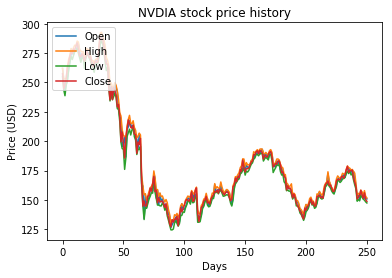

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(NVDA_data["Open"])
plt.plot(NVDA_data["High"])
plt.plot(NVDA_data["Low"])
plt.plot(NVDA_data["Close"])
plt.title('NVDIA stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

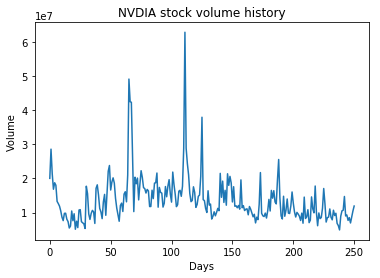

In [8]:
plt.figure()
plt.plot(NVDA_data["Volume"])
plt.title('NVDIA stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(NVDA_data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 200 51


In [32]:
x_train[x_train <0]

array([], dtype=float64)

In [37]:
TIME_STEPS = 10
BATCH_SIZE = 20
from tqdm import tqdm_notebook as tqdm
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [38]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [39]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (190, 10, 5) (190,)



length of time-series i/o (41, 10, 5) (41,)


In [45]:
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import Sequential
from keras import optimizers

lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
#optimizer = optimizers.RMSprop(lr=lr)
optimizer = optimizers.RMSprop()
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

WARNING - From C:\Users\ssreekan\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [51]:
from keras.callbacks import CSVLogger
OUTPUT_PATH = "C:"
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH ,'FirstLSTM_TimeSeries' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=100, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 180 samples, validate on 20 samples
Epoch 1/100
 - 2s - loss: 0.0973 - val_loss: 0.0796
Epoch 2/100
 - 0s - loss: 0.0920 - val_loss: 0.0710
Epoch 3/100
 - 0s - loss: 0.0827 - val_loss: 0.0344
Epoch 4/100
 - 0s - loss: 0.0800 - val_loss: 0.0210
Epoch 5/100
 - 0s - loss: 0.0670 - val_loss: 0.0081
Epoch 6/100
 - 0s - loss: 0.0598 - val_loss: 0.0060
Epoch 7/100
 - 0s - loss: 0.0438 - val_loss: 0.0098
Epoch 8/100
 - 0s - loss: 0.0346 - val_loss: 0.0045
Epoch 9/100
 - 0s - loss: 0.0338 - val_loss: 0.0063
Epoch 10/100
 - 0s - loss: 0.0206 - val_loss: 0.0024
Epoch 11/100
 - 0s - loss: 0.0320 - val_loss: 0.0021
Epoch 12/100
 - 0s - loss: 0.0112 - val_loss: 0.0032
Epoch 13/100
 - 0s - loss: 0.0178 - val_loss: 0.0019
Epoch 14/100
 - 0s - loss: 0.0140 - val_loss: 0.0053
Epoch 15/100
 - 0s - loss: 0.0145 - val_loss: 0.0035
Epoch 16/100
 - 0s - loss: 0.0104 - val_loss: 0.0019
Epoch 17/100
 - 0s - loss: 0.0092 - val_loss: 0.0060
Epoch 18/100
 - 0s - loss: 0.0139 - val_loss: 0.0042
Epoch 19/1

In [53]:
from sklearn.metrics import mean_squared_error
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.001171163080491993 (20,) (20,)
[0.23268154 0.2350125  0.24043638 0.24619713 0.24880567 0.26037273
 0.26141447 0.2694965  0.27350459 0.27851564 0.26274902 0.24032784
 0.21677473 0.17965451 0.17069253]
[0.26559031 0.25486816 0.27261529 0.29935918 0.31784574 0.28530939
 0.2957235  0.29418296 0.29806507 0.25659356 0.23317722 0.21019228
 0.14610546 0.15571855 0.16520828]


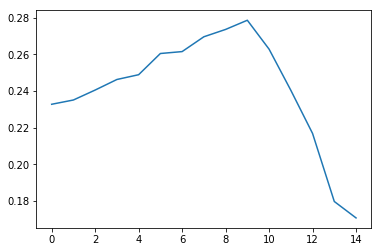

In [54]:
plt.plot(y_pred[0:15])

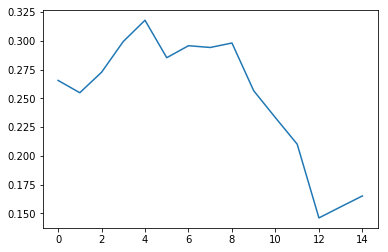

In [55]:
plt.plot(y_test_t[0:15])